# Experiments

In [40]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm

rng = np.random.default_rng()

In [23]:
# utility functions
normalize = lambda x, dim=-1: x /np.sum(x, axis=dim)

## 1D Case


In [19]:
means = [1., 5., 10.]
stds = rng.random(3) + .05
t = np.linspace(-5, 15, 100)

In [20]:
stds

array([0.95345664, 0.28633944, 0.88233923])

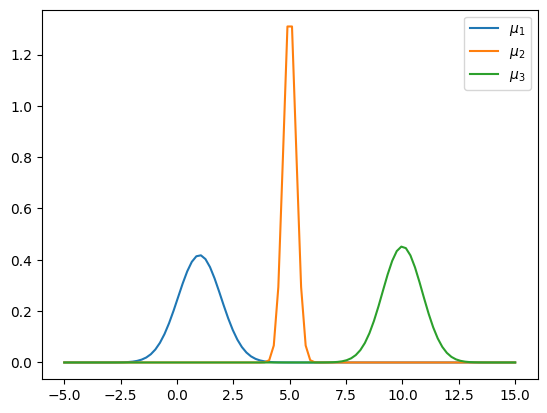

In [21]:
fig = plt.figure()

plt.plot(t, norm.pdf(t, loc=means[0], scale=stds[0]), label='$\mu_1$')
plt.plot(t, norm.pdf(t, loc=means[1], scale=stds[1]), label='$\mu_2$')
plt.plot(t, norm.pdf(t, loc=means[2], scale=stds[2]), label='$\mu_3$')

plt.legend()
plt.show()

### Method on a fixed grid 

In [28]:
# fixed grid 
M = 800
x = np.linspace(-5, 15, M)

**Method 1 :** Compute the barycenter on a refined grid using the inverse cumulative function

In [ ]:
# coeffs = np.zeros(M)

**Method 2:** Using regularized bregman method

Here, the input measures have to be discretized on the same grid as the target barycenter.

In [38]:
A = np.zeros((M, 3))
vmin = .02
for j in range(3):
    a = norm.pdf(x, loc=means[j], scale=stds[j])
    A[:, j] = normalize( a + a.max()*vmin)

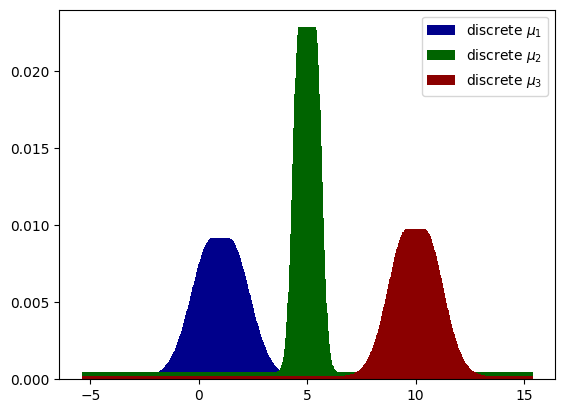

In [39]:
fig = plt.figure()

plt.bar(x, A[:, 0], label='discrete $\mu_1$', color = 'darkblue')
plt.bar(x, A[:, 1], label='discrete $\mu_2$', color = 'darkgreen')
plt.bar(x, A[:, 2], label='discrete $\mu_3$', color = 'darkred')
plt.legend()

plt.show()

In [41]:
# Bregman algo
# uniform weights
weights = np.ones(3) / 3

# Kernel 
epsilon = .05
[Y, X] = np.meshgrid(x, x)
K = np.exp(- (X - Y)**2/ epsilon )

# initialization 
v = np.ones((M, 3))
u = np.copy(v)

niter = 500
for i in tqdm(range(niter)):
    
    # update u
    for k in range(3): 
        u[:, k] = A[:, k] / np.dot(K, v[:, k])
    
    # compute barycenter
    b = np.zeros(M)
    for k in range(3):
        b += weights[k] * np.log( np.maximum(v[:, k] * np.dot(K, u[:, k]),
                                             1e-19*np.ones(M)))
    b = np.exp(b)

    # update v
    for k in range(3):
        v[:, k] = b / np.dot(K, u[:, k])
    

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:00<00:00, 204.20it/s]


In [44]:
b = normalize(b)

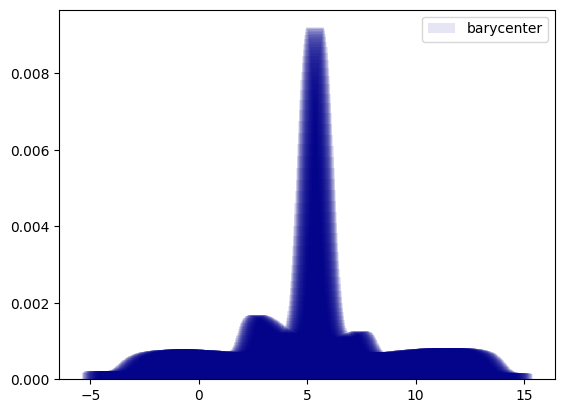

In [46]:
plt.bar(x, b, label='barycenter', color = 'darkblue')

plt.legend()
plt.show()

**Method 3:** Stochastic wasserstein barycenter without refined grid 

In [ ]:
n_samples = 1000 
nIter = 20
J = 3

In [ ]:
def compute_gradient_a(phi, Y):
    """ using Monte Carlo method"""
    raise NotImplementedError

In [ ]:
# for t in range(nIter):
#     # ascent step 
#     for j in range(J):
#         z_0 = 0
#         w_0 = phi_j

#     # snap step 